# Train a model on Parkinson telemonitoring data

## Retrieve data

In [1]:
#pip install -r requirements.txt
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
from ucimlrepo import fetch_ucirepo 

  
# fetch dataset 
parkinson = fetch_ucirepo(id=189)
df = parkinson.data
  
# data (as pandas dataframes) 
X = parkinson.data.features 
y = parkinson.data.targets 

y_motor = y.motor_UPDRS	
y_total = y.total_UPDRS
  
# variable information 
parkinson.variables

,name,role,type,demographic,description,units,missing_values
0,subject#,ID,Integer,None,Integer that uniquely identifies each subject,None,no
1,age,Feature,Integer,Age,Subject age,None,no
2,test_time,Feature,Continuous,None,Time since recruitment into the trial. The int...,None,no
3,Jitter(%),Feature,Continuous,None,Several measures of variation in fundamental f...,None,no
4,Jitter(Abs),Feature,Continuous,None,Several measures of variation in fundamental f...,None,no
5,Jitter:RAP,Feature,Continuous,None,Several measures of variation in fundamental f...,None,no
6,Jitter:PPQ5,Feature,Continuous,None,Several measures of variation in fundamental f...,None,no
7,Jitter:DDP,Feature,Continuous,None,Several measures of variation in fundamental f...,None,no
8,Shimmer,Feature,Continuous,None,Several measures of variation in amplitude,None,no
9,Shimmer(dB),Feature,Continuous,None,Several measures of variation in amplitude,None,no


In [4]:
df = pd.concat([X, y], axis=1)
df

,age,test_time,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,...,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE,sex,motor_UPDRS,total_UPDRS
0,72,5.6431,0.00662,0.000034,0.00401,0.00317,0.01204,0.02565,0.230,0.01438,...,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006,0,28.199,34.398
1,72,12.6660,0.00300,0.000017,0.00132,0.00150,0.00395,0.02024,0.179,0.00994,...,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810,0,28.447,34.894
2,72,19.6810,0.00481,0.000025,0.00205,0.00208,0.00616,0.01675,0.181,0.00734,...,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014,0,28.695,35.389
3,72,25.6470,0.00528,0.000027,0.00191,0.00264,0.00573,0.02309,0.327,0.01106,...,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277,0,28.905,35.810
4,72,33.6420,0.00335,0.000020,0.00093,0.00130,0.00278,0.01703,0.176,0.00679,...,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361,0,29.187,36.375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5870,61,142.7900,0.00406,0.000031,0.00167,0.00168,0.00500,0.01896,0.160,0.00973,...,0.01549,0.02920,0.025137,22.369,0.64215,0.55314,0.21367,0,22.485,33.485
5871,61,149.8400,0.00297,0.000025,0.00119,0.00147,0.00358,0.02315,0.215,0.01052,...,0.01904,0.03157,0.011927,22.886,0.52598,0.56518,0.12621,0,21.988,32.988
5872,61,156.8200,0.00349,0.000025,0.00152,0.00187,0.00456,0.02499,0.244,0.01371,...,0.01877,0.04112,0.017701,25.065,0.47792,0.57888,0.14157,0,21.495,32.495
5873,61,163.7300,0.00281,0.000020,0.00128,0.00151,0.00383,0.01484,0.131,0.00693,...,0.01307,0.02078,0.007984,24.422,0.56865,0.56327,0.14204,0,21.007,32.007


## Train model

   age  test_time  Jitter(%)  Jitter(Abs)  Jitter:RAP  Jitter:PPQ5  \
0   72     5.6431    0.00662     0.000034     0.00401      0.00317   
1   72    12.6660    0.00300     0.000017     0.00132      0.00150   
2   72    19.6810    0.00481     0.000025     0.00205      0.00208   
3   72    25.6470    0.00528     0.000027     0.00191      0.00264   
4   72    33.6420    0.00335     0.000020     0.00093      0.00130   

   Jitter:DDP  Shimmer  Shimmer(dB)  Shimmer:APQ3  ...  Shimmer:APQ11  \
0     0.01204  0.02565        0.230       0.01438  ...        0.01662   
1     0.00395  0.02024        0.179       0.00994  ...        0.01689   
2     0.00616  0.01675        0.181       0.00734  ...        0.01458   
3     0.00573  0.02309        0.327       0.01106  ...        0.01963   
4     0.00278  0.01703        0.176       0.00679  ...        0.01819   

   Shimmer:DDA       NHR     HNR     RPDE      DFA      PPE  sex  motor_UPDRS  \
0      0.04314  0.014290  21.640  0.41888  0.54842  0.16006

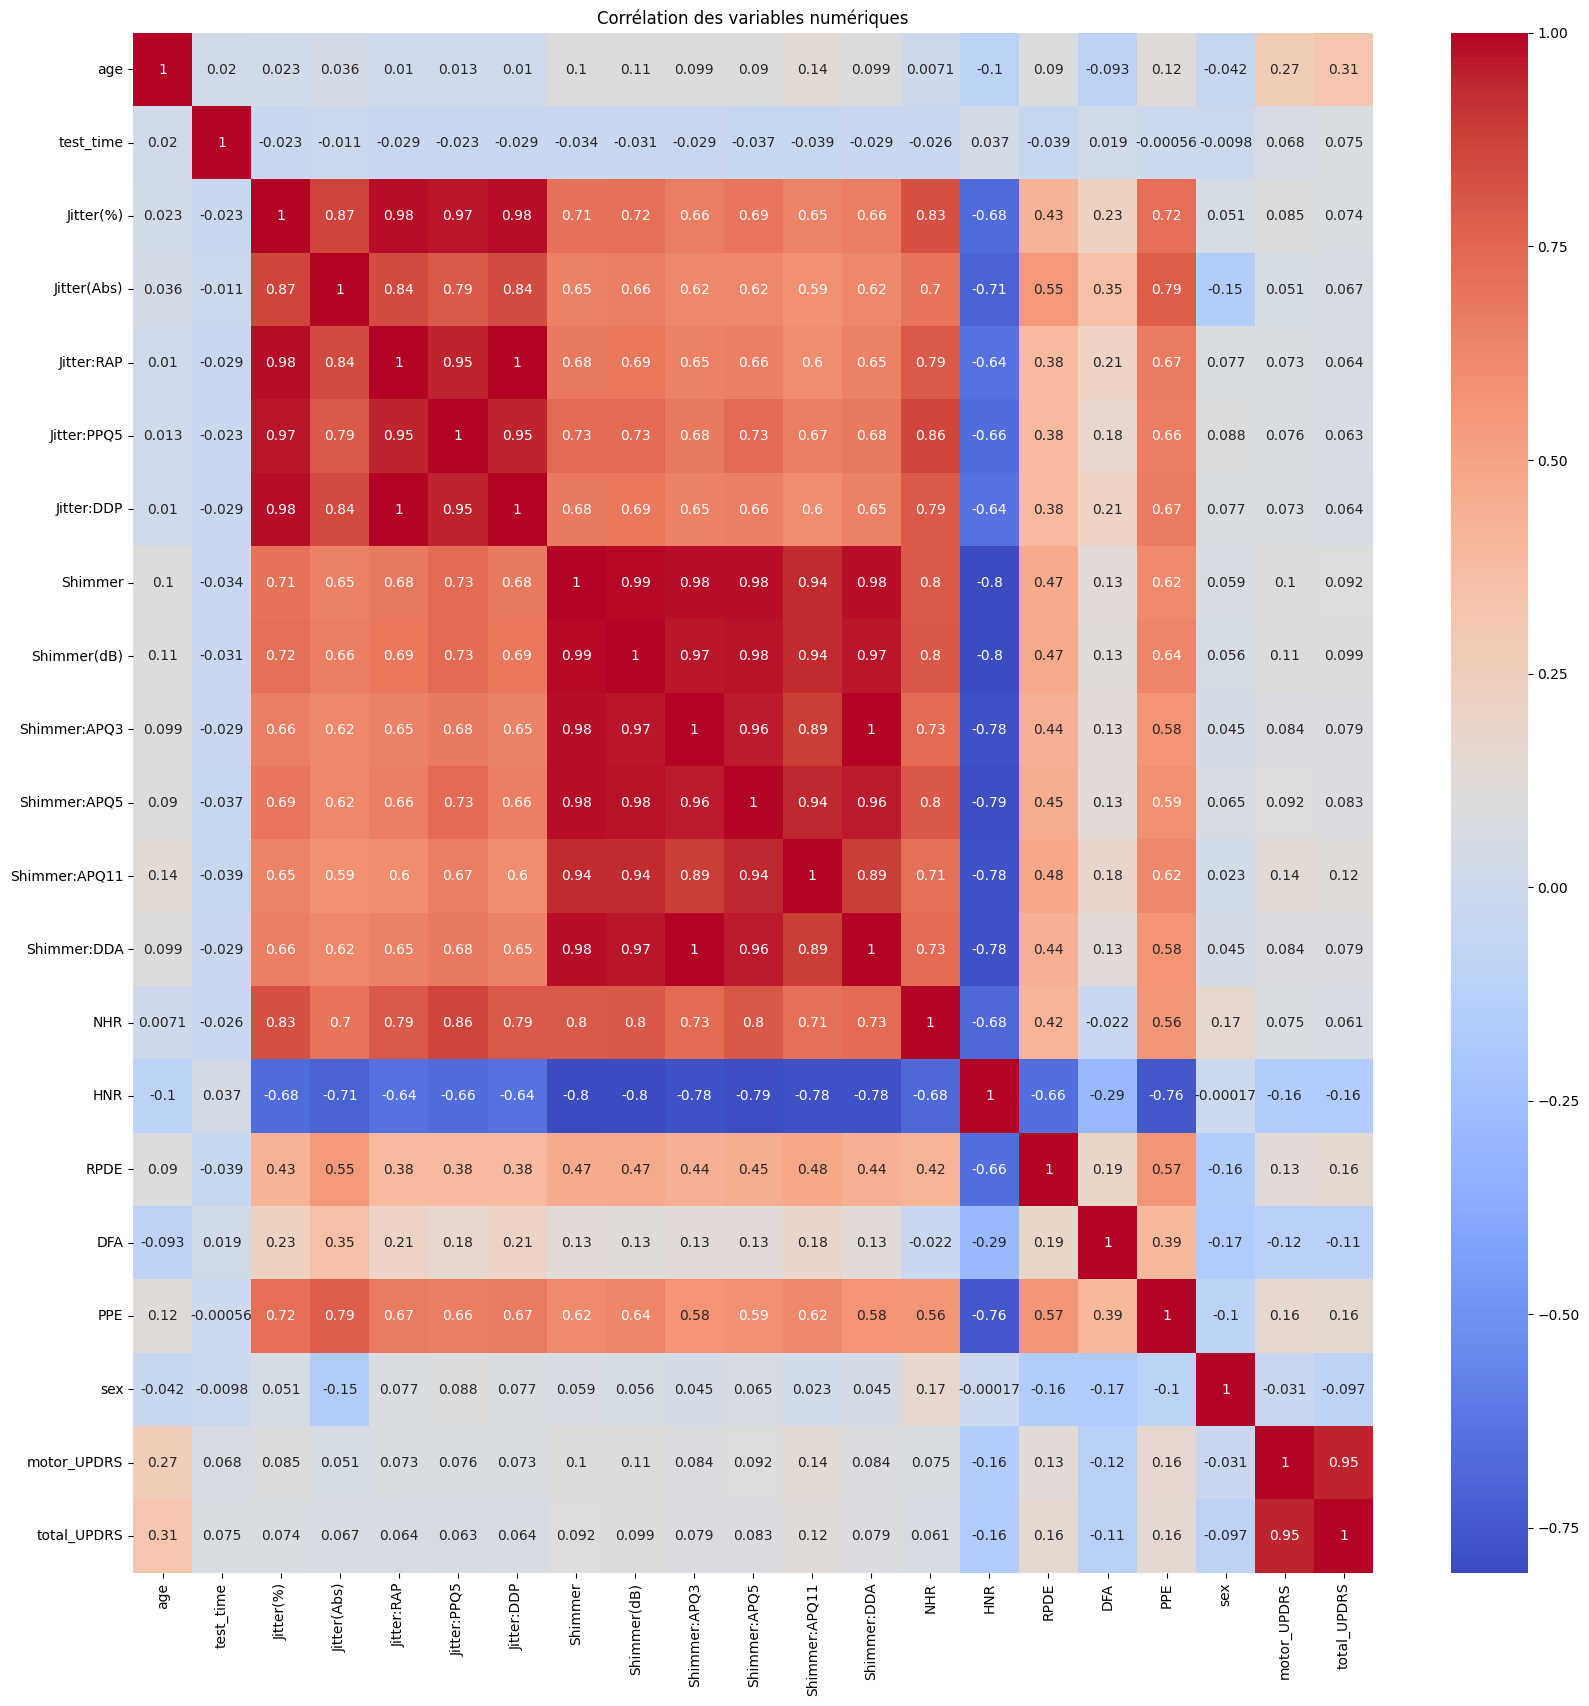

In [5]:
# Exploration minimale
print(df.head())
print(df.info())
print(df.describe())

# sns.pairplot(df.sample(200), diag_kind='kde')
# plt.suptitle("Pairplot de l'échantillon", y=1.02)
# plt.show()
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Corrélation des variables numériques")
plt.show()

In [6]:
# Prétraitement : uniquement numérique, donc normalisation
preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), X.columns)
])

In [7]:
# Modèles à tester
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42)
}

# Split des données
X_train, X_test, y_train, y_test = train_test_split(X, y_total, test_size=0.2, random_state=42)

# Entraînement et évaluation
trained_models = {}

for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    print(f"\n=== {name} ===")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
    print(f"R² Score: {r2_score(y_test, y_pred):.2f}")
    
    trained_models[name] = pipeline


=== LinearRegression ===
RMSE: 9.66
R² Score: 0.16

=== RandomForest ===
RMSE: 1.62
R² Score: 0.98

=== XGBoost ===
RMSE: 2.03
R² Score: 0.96


# Explicabilité globale

Le Random Forest ayant les meilleures performances, nous allons appliquer le modèle RandomForestRegressor

In [9]:
preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), X.columns)
])

model = RandomForestRegressor(n_estimators=100, random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model)
])

X_train, X_test, y_train, y_test = train_test_split(X, y_total, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)

X_train_transformed = pipeline["preprocessor"].transform(X_train)
X_test_transformed = pipeline["preprocessor"].transform(X_test)

y_pred = pipeline.predict(X_test)
print(f"Random Forest Regressor - RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"Random Forest Regressor - R² Score: {r2_score(y_test, y_pred):.2f}")

Random Forest Regressor - RMSE: 1.62
Random Forest Regressor - R² Score: 0.98


## Explicabilité SHAP

C:\Users\doria\AppData\Local\Temp\ipykernel_14364\3021567124.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, features=X_test_transformed, feature_names=X.columns)


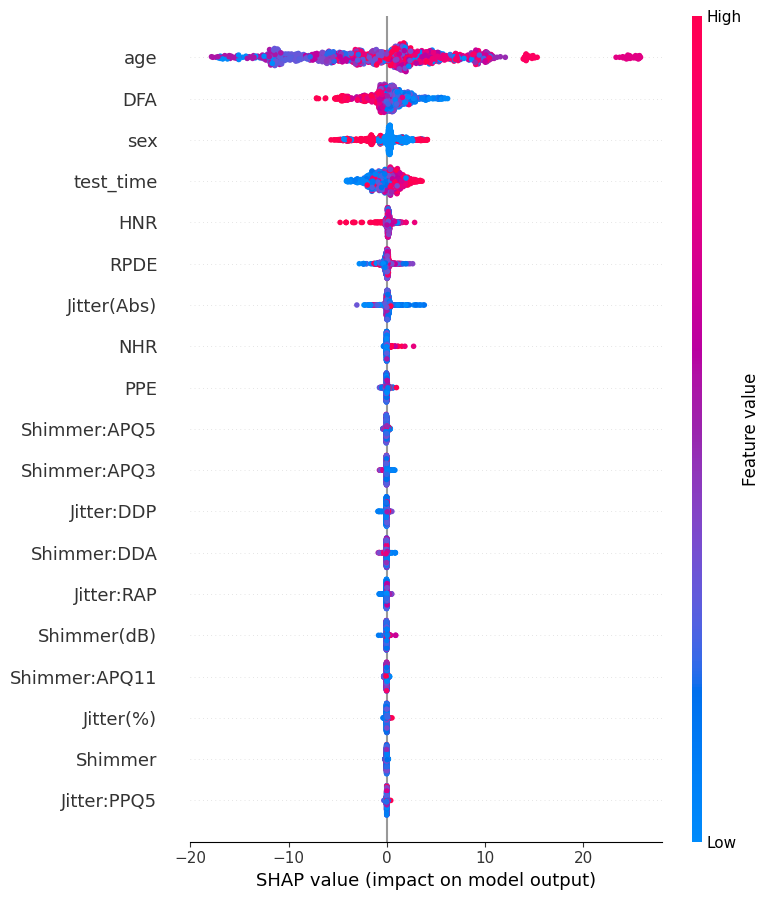

In [26]:
import shap

explainer = shap.Explainer(model)
shap_values = explainer(X_test_transformed)

shap.summary_plot(shap_values, features=X_test_transformed, feature_names=X.columns)

In [27]:
import shap
import ipywidgets as widgets
from IPython.display import display, HTML

shap.initjs()

# Force plot interactif
def show_force_plot(index):
    force_plot = shap.force_plot(
        explainer.expected_value,
        shap_values[index].values,
        features=X_test_transformed[index],
        feature_names=X.columns,
        matplotlib=False  # version JavaScript interactive
    )
    
    html = f"""
    <div style='background-color:white;padding:10px'>
        {force_plot.html()}
    </div>
    """ # fond blanc
    display(HTML(html))

# Slider pour choisir l’index (la ligne sur laquelle appliquer le SHAP local)
index_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(X_test_transformed) - 1,
    step=1,
    description='Index:',
    continuous_update=False
)

widgets.interact(show_force_plot, index=index_slider);


interactive(children=(IntSlider(value=0, continuous_update=False, description='Index:', max=1174), Output()), …

## Explicabilité Partial Dependency Plot

Le PdP peut directement prendre une pipeline en paramètre, pas besoin d'utiliser `X_train_transformed` et `X_train_transformed`

In [28]:
from saan_xai.pdp import plot_partial_dependence_interactive

plot_partial_dependence_interactive(
    pipeline=pipeline,
    X_test=X_test,
    features=list(X.columns),
    kind="average",
    grid_resolution=50,
    figsize=(7,4)
)

interactive(children=(Dropdown(description='Feature:', layout=Layout(width='300px'), options=('age', 'test_tim…

Output()

## Prédiction ALE

Pour la prédiction ALE, deux librairies sont testées et comparées : `PyALE`et `alibi`

### PyALE

La librairie PyALE peut directement recevoir en input une pipeline sklearn, ce qui évite de devoir décomposer les étapes de la pipeline.

L'affichage d'un intervalle de confiance est également possible via les paramètres `include_CI`et `C`.

Ici nous réalisons un graphique par feature. Pour éviter de trop surcharger le notebook, seules les 7 poremières features sont affichées.


In [29]:
from saan_xai.ale import plot_ale_interactive

plot_ale_interactive(
    model=pipeline,
    X_test=X_test,
    features=None,  # None pour toutes
    grid_size=50,
    include_CI=True,
    C=0.95,
    figsize=(10, 6)
)

interactive(children=(Dropdown(description='Feature:', layout=Layout(width='300px'), options=('age', 'test_tim…

Output()

### Alibi

Avec Alibi, nous devons décomposer notre objet pipeline, car il ne prend que les modèles sklearn.

De plus, le package alibi ne prend pas en charge l'affichage des intervalles de confiance, ou la distribution des différentes features.

Enfin, pour pouvoir l'importer, il vous faut une version de numpy inférieur à 2, ce qui peut être contraignant sur le reste de votre projet.

In [30]:
from saan_xai.ale import plot_alibi_ale_interactive

plot_alibi_ale_interactive(
    model=pipeline["regressor"],
    X_test=pipeline["preprocessor"].transform(X_test),
    features=X_test.columns,  # or None for all features if X_test is a dataframe
    figsize=(10,6)
)

interactive(children=(Dropdown(description='Feature:', layout=Layout(width='300px'), options=('age', 'test_tim…

Output()

## LOFO

In [10]:
import matplotlib.pyplot as plt
from lofo import LOFOImportance, Dataset, plot_importance, FLOFOImportance

c:\Users\doria\Documents\Mathilde\Fil rouge\fil_rouge_env\Lib\site-packages\lofo\lofo_importance.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/20 [00:00<?, ?it/s]

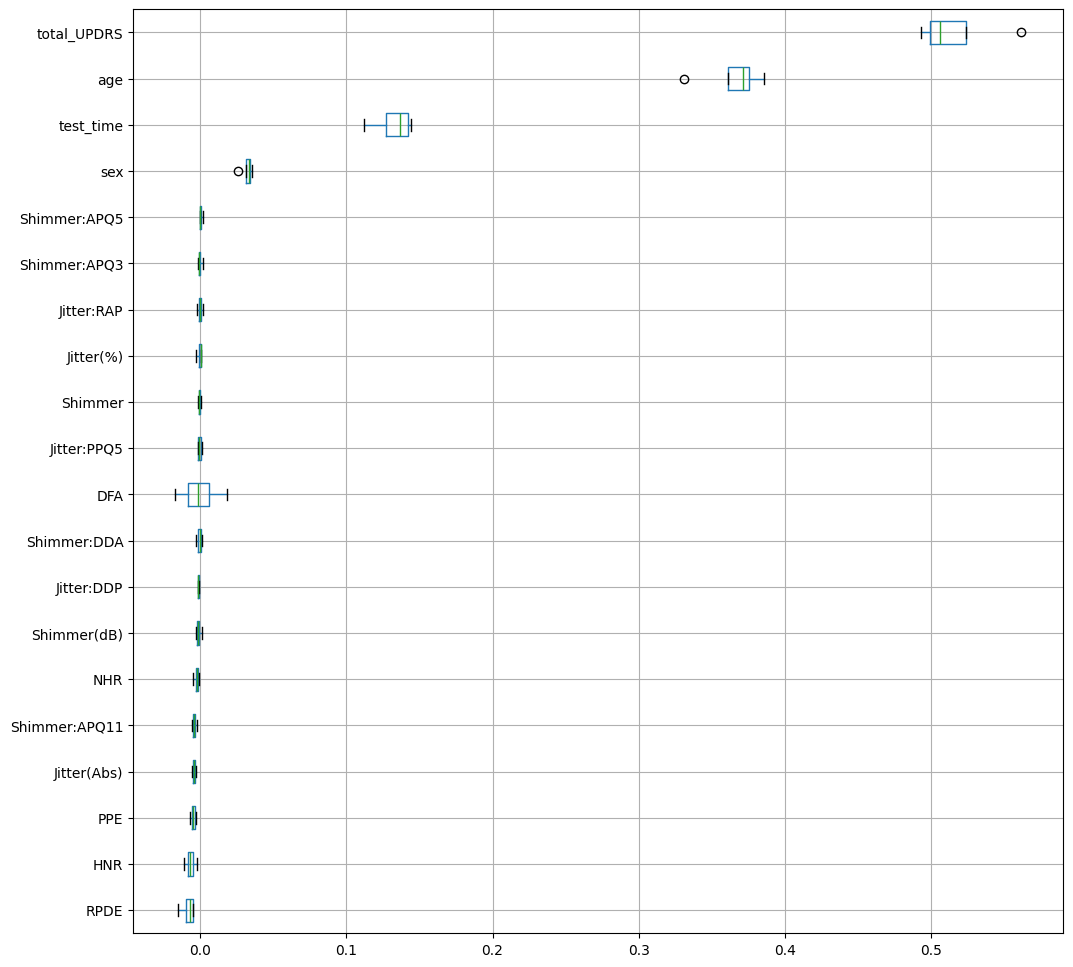

In [15]:
from sklearn.model_selection import KFold
cv = KFold(n_splits=4, shuffle=True, random_state=42)
dataset = Dataset(df=df, target="motor_UPDRS", features=[col for col in df.columns if col != "motor_UPDRS"])

lofo_imp = LOFOImportance(dataset, 
                          cv=cv, 
                          model=RandomForestRegressor(n_estimators=100, random_state=42), 
                          scoring="neg_mean_absolute_error")

# get the mean and standard deviation of the importances in pandas format
importance_df = lofo_imp.get_importance()

plot_importance(importance_df, figsize=(12, 12), kind="box")

  0%|          | 0/19 [00:00<?, ?it/s]

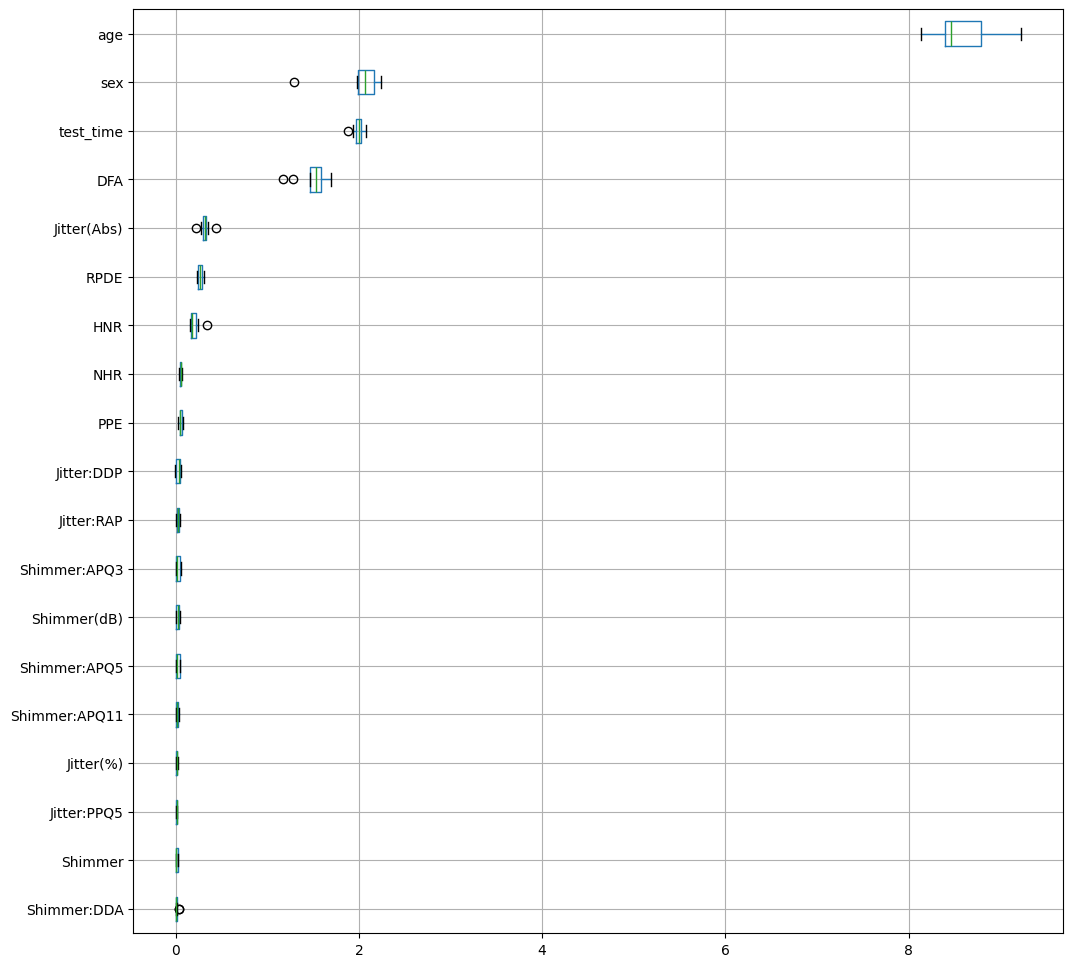

In [11]:
flofo_imp = FLOFOImportance(trained_model=pipeline, validation_df=pd.concat([X_test, y_test], axis=1), 
                           features=X_test.columns,
                           target = "total_UPDRS",
                           scoring="neg_mean_absolute_error")

# get the mean and standard deviation of the importances in pandas format
importance_df2 = flofo_imp.get_importance()

plot_importance(importance_df2, figsize=(12, 12), kind="box")

### **Local Methods**

#### **Lime** - Local

In [ ]:
# Prétraitement
preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), X.columns)
])

# Modèle XGBoost (on le prendra pour SHAP)
rf_model =RandomForestRegressor(n_estimators=100, random_state=42)

# Prétraitement séparé pour retrouver les données transformées
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Split on y_total
X_train_transformed, X_test_transformed, y_train, y_test = train_test_split(X, y_total, test_size=0.2, random_state=42)

# Entraînement
rf_model.fit(X_train_transformed, y_train)

# Prédiction et évaluation
y_pred = rf_model.predict(X_test_transformed)
print(f"XGBoost - RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"XGBoost - R² Score: {r2_score(y_test, y_pred):.2f}")

XGBoost - RMSE: 1.62
XGBoost - R² Score: 0.98


In [14]:
from lime.lime_tabular import LimeTabularExplainer

instance_idx = 2  # Indice de l'instance à expliquer
instance = X_test.values[instance_idx]

# Création de l'explainer LIME
explainer = LimeTabularExplainer(
    X_train.values,
    mode='regression',
    feature_names=X_train_transformed.columns.values.tolist(),  
    verbose=True,
)

# Explication locale
exp = explainer.explain_instance(instance,
                                rf_model.predict,
                                num_features = 5 # Number of features to show in the explanation
                                )
# Affichage de l'explication
exp.show_in_notebook()

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

#### **ICE** - Local

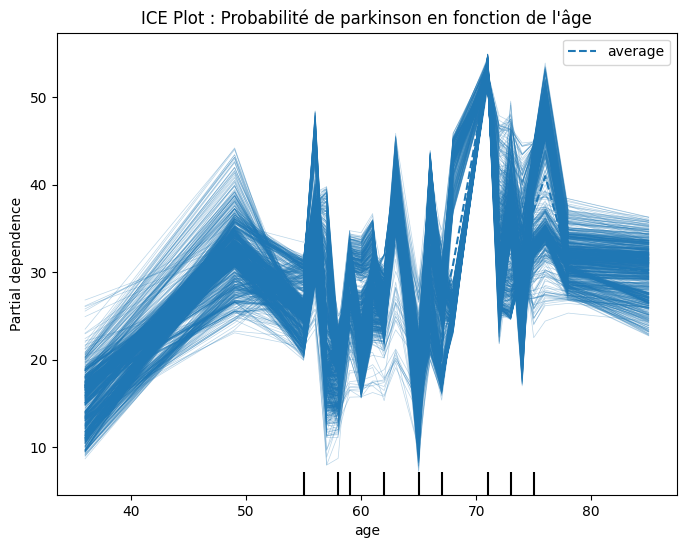

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence

# Tracer l'ICE plot
fig, ax = plt.subplots(figsize=(8, 6))
PartialDependenceDisplay.from_estimator(
    rf_model, X_train_transformed, features=[0], kind="both", ax=ax, grid_resolution=50
)
plt.title("ICE Plot : Probabilité de parkinson en fonction de l'âge")
plt.show()

#### **Anchors** - Local

For Anchors, we should turn the problem from a **regression** task to a **classification** one. 

In [ ]:
from alibi.explainers import AnchorTabular

# Création de l'explicateur Anchors avec la fonction prédictive
explainer = AnchorTabular(predictor=rf_model.predict, feature_names=X_train.columns.tolist())

# Ajustement avec les données d'entraînement
explainer.fit(X_train)

# Sélection d'une instance à expliquer
idx = 5  # Choix d'une instance arbitraire
instance = X_test_transformed[idx].reshape(1, -1)

# Génération de l'explication avec Anchors
exp = explainer.explain(instance)

# Affichage de la règle d'ancrage trouvée
print("\n🌟 Règle d'ancrage trouvée :")
print(exp.anchor)
print(f"⚡ Précision de la règle : {exp.precision:.2f}")
print(f"📊 Couverture de la règle : {exp.coverage:.2f}")

# Visualisation des résultats
plt.figure(figsize=(10, 5))
plt.barh(exp.data['anchor'], exp.data['precision'], color="dodgerblue")
plt.xlabel("Précision de la règle d’ancrage")
plt.ylabel("Caractéristiques sélectionnées")
plt.title("🎯 Précision des Règles d’Ancrage pour une Instance")
plt.show()

C:\Users\miche\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


InvalidIndexError: (slice(None, None, None), 0)